In [1]:
#####################
# IMPORT LIBS
#####################

import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBClassifier


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = False
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
###############
# Config
###############

n_seed = 3
n_fold = 3
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [3]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [4]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

/opt/conda/lib/python3.7/site-packages/decorator.py:231: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  return caller(func, *(extras + args), **kw)


CPU times: user 9.61 s, sys: 843 ms, total: 10.5 s
Wall time: 10.6 s


In [5]:
payments = payments.sort_values(by='day_dt', ascending = False).reset_index(drop = True)

In [17]:
target = ((funnel['sale_flg'] * funnel['sale_amount'].fillna(0) - funnel['contacts'].fillna(0)*400/0.1) > -4000).astype(int)

In [26]:
np.quantile(target, 0.1)

-8000.0

In [46]:
np.quantile(target, 0.84)

-964.6999999999998

In [47]:
Y_predicted = (target > np.quantile(target, 0.84)).astype(int).values
Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
test_funnel =  funnel.set_index('client_id')

public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)
print(1/3*public_score + 2/3*private_score)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


6683.11812261606


/home/jupyter/idao-2021-finals/scoring/scorer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['gain'] = selected[SALE_FLAG] * selected[SALE_AMOUNT].fillna(0) - selected[CONTACTS] * CALL_COST


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

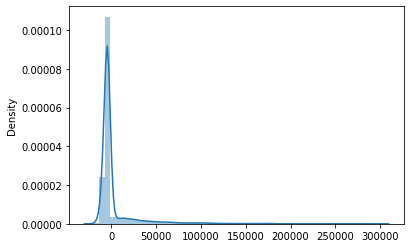

In [34]:
import seaborn as sns
sns.distplot(target)

## Data prep

In [9]:
ransactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')

balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')

client = client.rename(columns={
    'gender': 'client_gender',
    'age': 'client_age',
    'region': 'client_region',
    'city': 'client_city',
    'citizenship': 'client_citizenship',
    'education': 'client_education',
    'job_type': 'client_job_type'
})

In [94]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['c
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data = data.merge(client, on='client_id')
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['number_of_deals'] = data['client_id'].map(deals.groupby('client_id')['crncy_cd'].count()).fillna(0)
    data['mean_deal_sum'] = data['client_id'].map(deals.groupby('client_id')['agrmnt_sum_rur'].mean()).fillna(0)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return datalient_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)

def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].mean()).fillna(-1) # add monthly, daily, etc
#     data['std_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].std()).fillna(0) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    return data

def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = data['client_id'].map(assets_under_management.groupby('client_id')['balance_rur_amt'].mean()).fillna(-1)
    data['std_balance_rur_amt'] = data['client_id'].map(assets_under_management.groupby('client_id')['balance_rur_amt'].mean()).fillna(-1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data

def create_feautures_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data

def create_features_deals(data):
    data = data.copy()
    
    data['number_of_deals'] = data['client_id'].map(deals.groupby('client_id')['crncy_cd'].count()).fillna(0)
    data['mean_deal_sum'] = data['client_id'].map(deals.groupby('client_id')['agrmnt_sum_rur'].mean()).fillna(0)
    
    return data

In [160]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [161]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_feautures_payments(data)
# data = create_features_deals(data)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.78 µs


In [162]:
# data['sale_flg'] = data['sale_flg'] * data['sale_amount'].fillna(0) - data['contacts'] * 400 / 0.1

In [80]:
# data encode

# fill_cols = ['gender', 'citizenship', 'education', 'job_type',]# 'most_common_txn_city', 'most_common_tsp_name', 'most_common_txn_comment_1', 'most_common_txn_comment_2']
# for c in fill_cols:
#     col_type = data[c].dtype
#     if col_type == 'object' or col_type.name == 'category':
#         data[c] = data[c].astype('category')

In [198]:
# fill_cols = ['gender', 'citizenship', 'education', 'job_type', 'most_common_txn_city', 'most_common_tsp_name', 'most_common_txn_comment_1', 'most_common_txn_comment_2']# 'most_common_txn_city', 'most_common_tsp_name', 'most_common_txn_comment_1', 'most_common_txn_comment_2']
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('str')

In [164]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

## Train

In [165]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [194]:
cat_feats =[]
for c in X.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        cat_feats.append(np.argwhere(X.columns == c)[0][0])

In [190]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    
    params = {
              "n_jobs":-1,
              "random_state": seed,
              'objective': 'quantile',
              }
    
    
    model = LGBMRegressor(**params) # define model here
    model = CatBoostClassifier(thread_count=-1)
    
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False, cat_features=cat_feats)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False, cat_features=cat_feats)
    #joblib.dump(model, OUTPUT_PATH / 'models' / f'catboost_{i_fold}_{seed}_{CURRENT_TIME}.pkl')
    model.save_model(OUTPUT_PATH / 'models' / f'catboost_{i_fold}_{seed}_{CURRENT_TIME}')

In [168]:
import xgboost as xgb
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

Seed: 948, 1/3
# Fold: 1/3 (seed: 1/3)
predict on oof...  done.
# Fold: 2/3 (seed: 1/3)
predict on oof...  done.
# Fold: 3/3 (seed: 1/3)
predict on oof...  done.
Seed: 534, 2/3
# Fold: 1/3 (seed: 2/3)
predict on oof...  done.
# Fold: 2/3 (seed: 2/3)
predict on oof...  done.
# Fold: 3/3 (seed: 2/3)
predict on oof...  done.
Seed: 432, 3/3
# Fold: 1/3 (seed: 3/3)
predict on oof...  done.
# Fold: 2/3 (seed: 3/3)
predict on oof...  done.
# Fold: 3/3 (seed: 3/3)
predict on oof...  done.


In [177]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [181]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [182]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [183]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

Public ANIC 5350.509921853201 Private ANIC 5701.379291096846
ANIC 5584.422834682297
Accuracy score: 0.8113778025862871


In [191]:
if retrain_after_valid:
    running_train(X, Y, None, None, i_fold=-1, seed=4444)

In [330]:
if USE_WANDB:
    wandb.run.summary["validation_accuracy"] = validation_accuracy
    wandb.run.summary["anic"] = 1/3*public_score+ 2/3 * private_score

AttributeError: 'NoneType' object has no attribute 'summary'

In [100]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [101]:
if USE_WANDB:
    run.finish()

validation_accuracy,0.84343
anic,5471.22899
